### CS 575 Final Project

Description and solution to the final project in CS 575 for fall semester 2025.

- Mike Goodrich
- Brigham Young University
- March 2025

---

### Prior Project

The previous project constructed the person-person network by
- constructing a knowledge graph with the following 
  - node types
    - person
    - thread
    - channel
  - edge types
    - posted in thread
    - posted in channel
    - replied to
- using one-mode projection to form the person-person network

The project then had students apply node metrics and graph partitioning metrics to find 
- influential nodes
- community structures and inter-community bridges

Given the influential nodes and community structures, students then had to 
- develop a strategy for choosing early adopters so that a complex contagion could spread on the network
- simulate the complex contagion on the network to see how well their design worked

---


### Proposed Project

The proposed project shifts from social structure to semantic structure. A different graph schema will be used so that students can build a network that connects related messages. The proposed learning objectives are

**Learning Objectives**
- Design a knowledge graph schema based on textual content.
- Apply embedding techniques to short, informal text.
- Use GNNs to embed nodes based on content and relationships.
- Interpret clusters of embedded text data.

I've worked with ChatGPT-4o to create the following specification. The rest of this notebook will elaborate and implement the specification.

1. **Build the Knowledge Graph**
  - Nodes: Messages (from edges.csv — each message is a unique edge with content).
  - Edges between messages (Students will use edges.csv and nodes.csv to map messages to threads/channels/authors.):
    - Same author
    - Same recipient
    - Same channel
    - Same thread
    - Optional: same author and receiver
    - Optional: time adjacency (within X minutes in same thread)


2. **Form "Related Message" Network**
  - Find biadjacency matrix with messages as columns
  - Use one-mode projection to form adjacency matrix for which messages are related to which other messages

3. **Extract Feature Vectors for Messages**
  - Use one of the feature extraction strategies above. These are precanned methods for extracting features that won't be taught in class.
  - The feature vector for each message node is initialized with its vector.

4. **Train a GNN to Learn Embeddings**
  - Use a simple GCN or GAT with 2–3 layers.
  - Train using unsupervised objectives (e.g., Deep Graph Infomax or contrastive loss). I propose to use _reconstruction loss_ since I'll have taught that
  - Alternatively, treat it as node classification if you can weakly label messages by topics (optional).

5. **Visualize and Cluster**
  - Project the learned node embeddings using t-SNE or UMAP.
  - Cluster using KMeans or DBSCAN.
  - Display representative messages from each cluster.

6. **Analyze**
  - What kinds of messages cluster together?
  - Do clusters correlate with authors, channels, threads?
  - How do different edge definitions affect the graph (e.g., adding reply edges vs. not)?

The remainder of this notebook will go through these steps.

---

### Build the Knowledge Graph

#### Step 1: Extract Nodes

Read the `nodes.csv` file into a pandas dataframe and inspect the header. 


In [63]:
import pandas as pd
nodes_data = pd.read_csv('cs236_data/nodes.csv')
nodes_data.head()

,node,type,value
0,530,person,TA
1,0,person,TA
2,80,person,Student
3,531,person,Student
4,162,person,Student


- The entries in the node column are unique _node IDs_
- The entries in the node column are _node types_
  - person
  - thread
  - channel
- The entries in the value column depend on the node type
  - person values are one of
    - TA
    - Student
    - Instrutor
  - channel values are one of the channels in the Discord server
    - general
    - project 1
    - etc
  - thread values are the names given to the thread which are one of the following
    - names chosen by the person initiating the thread
    - first few words from the message from which the thread spawned

We can illustrate this relationship.

<img src="figures/nodes_organization.png" alt="Hierarchical relationship among nodes in nodes.csv" width = "800">

Start building the knowledge graph by extracting three node types: person, channel, thread.  Each vertex in the graph will have three properties:
- unique vertex ID (which will not be the same as the node ID)
- vertex type
  - person
  - channel
  - thread
- vertex value
  - type of person
  - channel name
  - thread name

A _lurker_ is a member of a Discord server who never posts anything. I don't want to add lurkers as nodes to the graph because they won't be part of anything interesting.

In [64]:
node_set: set[int] = set(nodes_data['node'])
print(len(node_set))

edges_data = pd.read_csv('cs236_data/edges.csv')
edge_set: set[int] = set(edges_data['source']) | set(edges_data['target'])

lurkers: set[int] = node_set - edge_set
for i in lurkers:
    if i%10 == 0:
        print(f"node {i} is never part of a message")

671
node 530 is never part of a message
node 540 is never part of a message
node 550 is never part of a message
node 560 is never part of a message
node 570 is never part of a message
node 580 is never part of a message
node 590 is never part of a message
node 600 is never part of a message
node 610 is never part of a message
node 620 is never part of a message
node 630 is never part of a message
node 640 is never part of a message
node 650 is never part of a message
node 660 is never part of a message
node 670 is never part of a message


In [65]:
import networkx as nx
from typing import Tuple

def add_nodes_from_node_dataframe(dataframe: pd.DataFrame,
                                  G: nx.Graph,
                                  lurkers: set[int]
                                  ) -> Tuple[nx.Graph, dict[int, int]]:
    """ 
        Take an empty graph and populate it with nodes.
        Inputs
          • dataframe is a pandas dataframe for node types
          • G is a graph with no edges and no nodes
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • A dictionary that allows the vertex ID in the graph to be looked up
            from node ID in the file
        Note attributes
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) > 0:
        raise ValueError("Graph must be empty")
    
    nodeID_to_vertexID: dict[int, int] = dict()
    vertex_ID: int = 0

    # For each row in the nodes.csv dataframe, number the entries and skip lurkers
    for _, row in dataframe.iterrows():
        if int(row['node']) not in lurkers:
          G.add_node(vertex_ID,
                    node_ID = int(row['node']), 
                    node_type = str(row['type']),
                    node_value = str(row['value']))
          nodeID_to_vertexID[row['node']] = vertex_ID
          vertex_ID += 1
    return G, nodeID_to_vertexID


Confirm that we are getting the node that we want. 

In [66]:
G = nx.Graph()
G, nodeID_to_vertexID = add_nodes_from_node_dataframe(nodes_data, G, lurkers)
for node, attrs in G.nodes(data=True):
    print(f"node {node} has attributes: ID = {attrs.get('node_ID')}, type = {attrs.get('node_type')}, value = {attrs.get('node_value')[:2]}")
    if node > 10: 
        break

node 0 has attributes: ID = 0, type = person, value = TA
node 1 has attributes: ID = 80, type = person, value = St
node 2 has attributes: ID = 162, type = person, value = St
node 3 has attributes: ID = 7, type = person, value = St
node 4 has attributes: ID = 170, type = person, value = St
node 5 has attributes: ID = 158, type = person, value = St
node 6 has attributes: ID = 97, type = person, value = St
node 7 has attributes: ID = 172, type = person, value = St
node 8 has attributes: ID = 173, type = person, value = St
node 9 has attributes: ID = 65, type = person, value = St
node 10 has attributes: ID = 4, type = person, value = St
node 11 has attributes: ID = 179, type = person, value = TA


Look at graph to make sure things make sense

In [67]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from typing import Hashable

def show_graph(G: nx.Graph, 
               categories: list[str],
               pos: dict[Hashable, Tuple[float,float]] | None = None,
               title: str = "Graph from pandas dataframe"
               ) -> None:
    color_template: dict[str, str] = {'person': 'lightblue', 
                                    'thread': 'y', 
                                    'channel': 'salmon', 
                                    'message': 'm'}
    # Need to add error checking. That is where the categories argument will be used
    node_colors: list[str] = []
    for node in G.nodes():
        if G.nodes[node]['node_type'] == 'name':
            node_colors.append(color_template['name'])
        elif len(G.nodes[node]['node_type'].split(",")) > 1:
            node_colors.append(color_template['combo'])
        else:
            node_colors.append(color_template[G.nodes[node]['node_type']])

    plt.figure()
    #pos = nx.spring_layout(G)
    #pos = nx.nx_pydot.pydot_layout(G, prog="neato")
    if pos is None:
        try:
            pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
        except Exception as e:
            print(f"Graphviz layout failed, falling back to spring_layout: {e}")
            pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color = node_colors, alpha=0.5,node_size=20 )
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=0.5)
    
    # create and add legend
    legend_patches = [mpatches.Patch(color=color, label=category) for category, 
                    color in color_template.items() if category in categories]
    _ = plt.legend(handles=legend_patches, title="Node Types", loc="best")

    # Add the title
    _ = plt.title(title)
    _ = plt.axis('off')

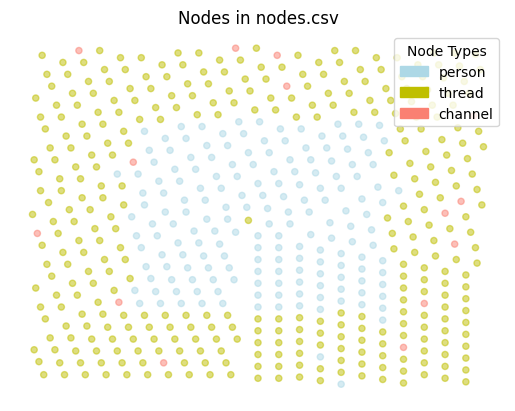

In [68]:
show_graph(G, ["person", "thread", "channel"], title = "Nodes in nodes.csv")

#### Step 2: Add Node for Each Message

Add a node for each message in `edges.csv`. The columns are
- _source_: the source of the message
- _target_: the destination of the message
- _edge type_: determined by the destimation of the message
  - `posted_in_channel` means the source is a person and the target is a channel
  - `replied_to` means the source is a person and the target is a person
  - `posted_in_thread` mens the source is a person and the target is a channel
  - `thread_in_channel` means the source is a thread and the thread is in a channel
- _content_: determined by the edge type
  - the message if the edge type is anything but `thread_in_channel`
  - empty if the edge type is `thread_in_channel`

We can illustrate this relationship.

<img src="figures/edges_organization.png" alt="Hierarchical relationship among edges in edges.csv" width = "600">

Let's confirm this pattern.

In [69]:
edges_data.head()

,source,target,edge_type,content
0,0,1,posted_in_channel,Project Submission Question
1,0,0,replied_to,I'm feeling better so I'll be in at around 11:30
2,0,2,replied_to,Nope
3,0,3,replied_to,Will there be any TAs today?
4,0,4,replied_to,"Yes, see the <#1148663286267641906> for specif..."


Check the unique values of edge_type.

In [70]:
edge_types = set(edges_data['edge_type'])
print(edge_types)

{'posted_in_thread', 'replied_to', 'thread_in_channel', 'posted_in_channel'}


Let's now create a vertex in the graph for each message.

In [71]:
def add_nodes_from_edges_dataframe(dataframe: pd.DataFrame,
                                   G: nx.Graph,
                                   ) -> nx.Graph:
    """ 
        Take a graph populated with nodes and add a node for each message
        Inputs
          • dataframe is a pandas dataframe for node types
          • G is a graph with no edges but with nodes having the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • vertexID_to_nodeID: a dictionary that allows easy mapping from the vertex
            number used in the graph to the node ID used in the database
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
        Note attributes
          • The node ID is an int
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) == 0:
        raise ValueError("Graph must be populated with nodes before adding messages")
    
    node_value: str  # C style type declaration
    num_non_message_nodes: int = len(G)

    # For each row in the nodes.csv dataframe
    for index, row in dataframe.iterrows():
        if row['content'] is None:
            if row['edge_type'] != 'channel_in_thread':
                raise ValueError("A message has empty content but is not a channel in thread")
            # empty content means that the edge type is a tread_in_channel
            continue
        else:
            node_value = str(row['content'])
            node_type = "message"
        G.add_node(index + num_non_message_nodes,
                   node_ID = index, 
                   node_type = node_type,
                   node_value = node_value)
    return G

Call the function and inspect the graph. There should be a ton of message nodes

In [72]:
print(len(edges_data))

1859


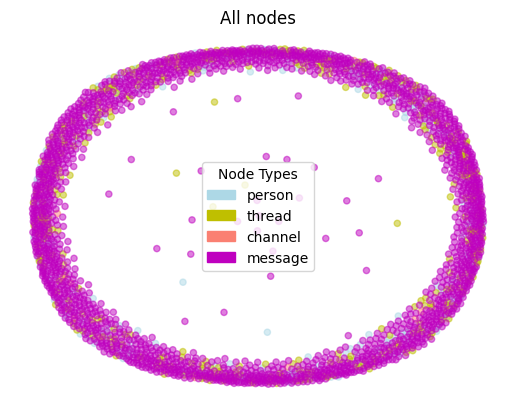

In [73]:
# We'll only include 500 fixed number of messages for now
#num_messages: int = 500
num_messages = len(edges_data)
G = add_nodes_from_edges_dataframe(edges_data.head(num_messages), G)
pos: dict[Hashable, tuple[float, float]] = nx.spring_layout(G)
show_graph(G, ["person", "thread", "channel", "message"], pos = pos, title = "All nodes")


Add edges. Since all information from `nodes.csv` is already in the graph, we only need to use information from `edges.csv`.

#### Step 3: Define Graph Schema

We must have a new graph schema when we include messages as graph vertices. 

<img src="figures/final_project_graph_schema.png" alt="Graph schema for final project with messages as graph vertices" width = "600">

The function that adds edges must implement this schema.

## TODO: Update the figure

It works best if the `channel` nodes are dropped since those nodes cause a lot of components to be complete.

#### Step 4: Add Edges According to the Schema

In [ ]:
def add_edges(G: nx.Graph,
              dataframe: pd.DataFrame,
              nodeID_to_vertexID: dict[int,int]
              ) -> nx.Graph:
    """ 
        Take a graph populated with nodes and add an edge according to the Graph Schema
        Inputs
          • G is a graph with no edges but with nodes having the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • dataframe is a pandas dataframe for node types
          • nodeID_to_vertexID: a dictionary that allows easy mapping from the node ID used 
            in the database to the vertex ID used in the graph
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
        Note attributes
          • The node ID is an int
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) == 0:
        raise ValueError("Graph must be populated with nodes before adding messages")
    

    num_nonmessage_nodes: int = len(nodeID_to_vertexID) 
    # For each row in the nodes.csv dataframe
    for index, row in dataframe.iterrows():
        # Error check
        if row['source'] not in nodeID_to_vertexID.keys():
            raise ValueError(f"Found a message in the edges without a legal source: source = {row['source']}, target={row['target']}")
        if row['target'] not in nodeID_to_vertexID.keys():
            raise ValueError(f"Found a message in the edges without a legal target: source = {row['source']}, target={row['target']}")
        if num_nonmessage_nodes + index not in set(G.nodes()):
            raise ValueError(f"edge {row} isn't connected to a legal node")
        
        # Find source, target, and middle if applicable
        source_vertex: int = nodeID_to_vertexID[row['source']]
        target_vertex: int = nodeID_to_vertexID[row['target']]
        message_vertex: int = num_nonmessage_nodes + index # Looks up message node ID

        # Add the edge
        if row['edge_type'] == 'replied_to':
            G.add_edge(source_vertex, message_vertex, edge_type = 'posted')
            G.add_edge(message_vertex, target_vertex, edge_type = 'received')
        elif row['edge_type'] == 'posted_in_channel':
            G.add_edge(source_vertex, message_vertex, edge_type = 'posted')
            G.add_edge(message_vertex, target_vertex, edge_type = 'posted_in_channel')
        elif row['edge_type'] == 'posted_in_thread':
            G.add_edge(source_vertex, message_vertex, edge_type = 'posted')
            G.add_edge(message_vertex, target_vertex, edge_type = 'posted_in_thread')
        else:
            G.add_edge(source_vertex, target_vertex, edge_type = 'thread_in_channel')
    return G

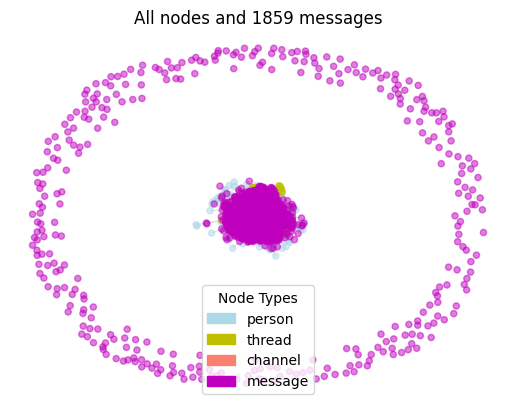

In [78]:
G = add_edges(G, edges_data.head(num_messages), nodeID_to_vertexID)
# Try to get position from graphviz
# try:
#     pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
# except Exception as e:
#     print(f"Graphviz layout failed, falling back to spring_layout: {e}")
#     pos = nx.spring_layout(G, seed=42)
pos = nx.spring_layout(G, seed=42)
show_graph(G, 
           ["person", "thread", "channel", "message"], 
           pos = pos,
           title = f"All nodes and {num_messages} messages")

Find out why some message nodes aren't linked anyplace.

In [79]:
print(f"There are {len(nodeID_to_vertexID)} non message nodes in the graph")
print(f"There are {len(edges_data)} lines in the edges data")

for node in G.nodes():
    if G.degree(node) == 0 and G.nodes[node]['node_type'] == 'message':
        print(f"node {node} is a message with no edges. Its discord ID is {G.nodes[node]['node_ID']} ")

There are 530 non message nodes in the graph
There are 1859 lines in the edges data
node 1984 is a message with no edges. Its discord ID is 1454 
node 1985 is a message with no edges. Its discord ID is 1455 
node 1986 is a message with no edges. Its discord ID is 1456 
node 1987 is a message with no edges. Its discord ID is 1457 
node 1988 is a message with no edges. Its discord ID is 1458 
node 1989 is a message with no edges. Its discord ID is 1459 
node 1990 is a message with no edges. Its discord ID is 1460 
node 1991 is a message with no edges. Its discord ID is 1461 
node 1992 is a message with no edges. Its discord ID is 1462 
node 1993 is a message with no edges. Its discord ID is 1463 
node 1994 is a message with no edges. Its discord ID is 1464 
node 1995 is a message with no edges. Its discord ID is 1465 
node 1996 is a message with no edges. Its discord ID is 1466 
node 1997 is a message with no edges. Its discord ID is 1467 
node 1998 is a message with no edges. Its discor

Work with the largest component

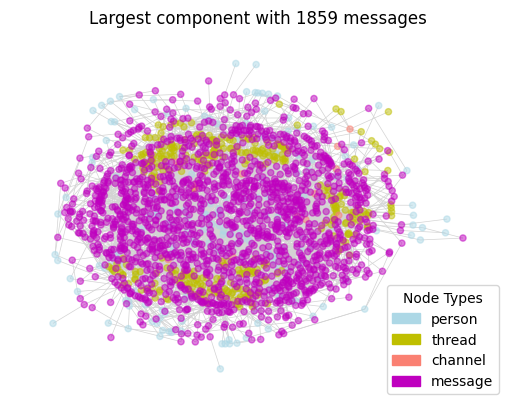

In [13]:
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph with only the largest component
largest_subgraph = G.subgraph(largest_cc).copy()
show_graph(largest_subgraph, 
           ["person", "thread", "channel", "message"],
           pos = pos,
           title = f"Largest component with {num_messages} messages")

---

### Form "Related Message" Network

#### Step 1: Find Biadjacency Matrix

In [14]:
import numpy as np
from numpy.typing import NDArray
def get_biadjacency_matrix(G: nx.Graph,
                           row_types: list[str],
                           column_types: list[str]
                           ) -> NDArray[np.float32]:
    # Error handling
    if len(row_types) == 0 or len(column_types) == 0:
        raise ValueError("Must specify node types for both row and column nodes")
    
    # Get list of nodes from each node partition
    list_0: list[Hashable] = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') in row_types] 
    if len(list_0) == 0:
        raise ValueError(f"There are no nodes in the graph with types from the row set {row_types}")
    list_1: list[Hashable] = sorted([node for node, attrs in G.nodes(data=True) if attrs.get('node_type') in column_types]) 
    if len(list_1) == 0:
        raise ValueError(f"There are no nodes in the graph with types from the column set {column_types}")


    biadjacency_matrix:NDArray = nx.bipartite.biadjacency_matrix(G, 
                                                                 row_order=list_0, 
                                                                 column_order=list_1).toarray()
    return biadjacency_matrix

In [15]:
#B = get_biadjacency_matrix(G, ['person', 'thread', 'channel'], ['message'])
B = get_biadjacency_matrix(G, ['person','thread'], ['message'])

print(B)

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Step 2: Create Adjacency Matrix

Use one-mode projection.

In [16]:
A = B.T@B
np.fill_diagonal(A, 0)
A[A > 1] = 1

#### Step 3: Create Graph 

The adjacency matrix can be used to create a new graph, but the graph will have lost the information about what is in the message nodes. Once we create the graph using the adjacency matrix, add the message information back into the nodes.

In [17]:
G_mm: nx.Graph = nx.from_numpy_array(A)

# Because I sorted the nodes in the "message" partition when I created the 
# biadjacency matrix, I can find a one-to-one mapping from the nodes in the
# new graph and the nodes in the old.

# Get sorted list of message nodes.
message_nodes: list[Hashable] = sorted([G.nodes[node]['node_value'] for node in G.nodes() if G.nodes[node]['node_type'] == 'message'])

print(f"There are {len(G_mm)} nodes in the new graph.")
print(f"There are {len(message_nodes)} in the old graph.")

for node_index in range(len(G_mm)):
    G_mm.nodes[node_index]['node_type'] = 'message'
    G_mm.nodes[node_index]['node_value'] = message_nodes[node_index]


max_messages: int = 15

for node in G_mm.nodes():
    print(f"Message {node} is {G_mm.nodes[node]['node_value']}")
    if node > max_messages:
        break


There are 1859 nodes in the new graph.
There are 1859 in the old graph.
Message 0 is (3,1) and (1,3) are in the relation, but (3,3) is not
Message 1 is **[EDIT]**: I moved this post to the project 1 tab because I felt that it was useful information. The original question was about whether the EOF token should have a newline after it or go straight to the Total Tokens line.
Message 2 is ...I'm only now seeing it. I suppose I'll just copy my code from Main to that file?
Message 3 is 10
Message 4 is 12, 7, 9, 1D right?
Message 5 is 2 options:
1
```
Use your diagram to encode the ID FSA to exclude RULES, FACTS, QUERIES, and SCHEMES as IDs
```
2
```
Add a condition in somewhere where if the ID FSA and the FACTS, SCHEMES, RULES, or QUERIES FSA both announce that they accept preference the keyword FSA
```
Message 6 is 25 points per question, standard late\early policy
Message 7 is 9, becuse there are 9 rules and our graph should show the dependancies between the rules
Message 8 is <@&11265682

In [51]:
for node in G_mm.nodes():
    if len(G_mm.nodes[node]['node_value']) <= 3:
        print(f"node {node} is a {G_mm.nodes[node]['node_type']} type with message = '{G_mm.nodes[node]['node_value']}'")

node 3 is a message type with message = '10'
node 332 is a message type with message = 'Hi'
node 814 is a message type with message = 'No'
node 815 is a message type with message = 'No'
node 1195 is a message type with message = 'Yes'
node 1196 is a message type with message = 'Yes'
node 1197 is a message type with message = 'Yes'
node 1280 is a message type with message = 'Yup'
node 1281 is a message type with message = 'Yup'
node 1282 is a message type with message = 'Yup'
node 1284 is a message type with message = '\n'
node 1317 is a message type with message = 'eq'
node 1408 is a message type with message = 'nan'
node 1409 is a message type with message = 'nan'
node 1410 is a message type with message = 'nan'
node 1411 is a message type with message = 'nan'
node 1412 is a message type with message = 'nan'
node 1413 is a message type with message = 'nan'
node 1414 is a message type with message = 'nan'
node 1415 is a message type with message = 'nan'
node 1416 is a message type with

Try to get the position from graphviz

In [18]:
try:
    pos_mm = nx.nx_pydot.graphviz_layout(G_mm, prog="neato")
except Exception as e:
    print(f"Graphviz layout failed, falling back to spring_layout: {e}")
    pos_mm = nx.spring_layout(G_mm, seed=42)

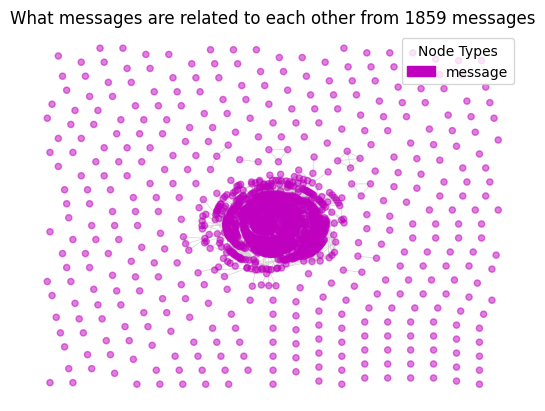

In [19]:
show_graph(G_mm, 
           ["message"], 
           pos = pos_mm,
           title = f"What messages are related to each other from {num_messages} messages")

Extract largest component

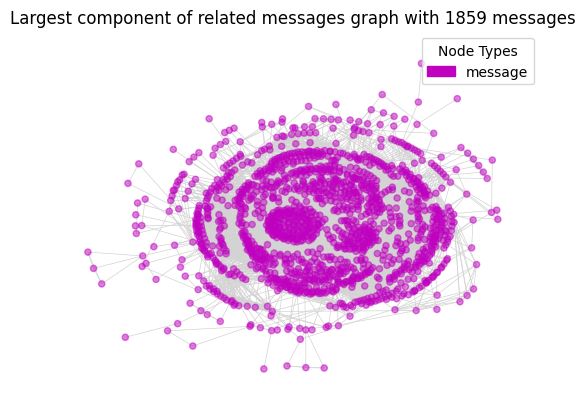

In [20]:
largest_cc = max(nx.connected_components(G_mm), key=len)
# Create a subgraph with only the largest component
largest_subgraph_mm = G_mm.subgraph(largest_cc).copy()
show_graph(largest_subgraph_mm,
           ["message"], 
           pos = pos_mm,
           title = f"Largest component of related messages graph with {num_messages} messages")

Show communities

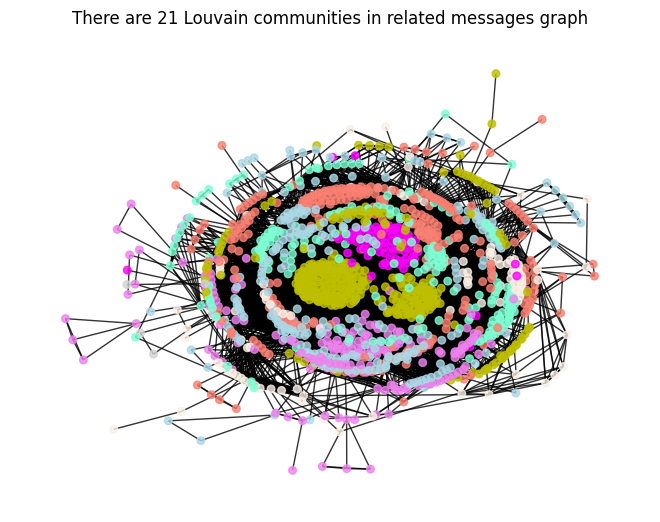

In [21]:
partition = nx.community.louvain_communities(largest_subgraph_mm)
color_list: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'magenta', 'lightgray', 'linen']
node_color: list[str] = []
for node in largest_subgraph_mm.nodes():
    for i, group in enumerate(partition):
        if node in group:
            node_color.append(color_list[i%len(color_list)])
            continue
nx.draw(largest_subgraph_mm,
        pos_mm,
        node_color = node_color,
        alpha = 0.8,
        node_size = 30)
_ = plt.title(f"There are {len(partition)} Louvain communities in related messages graph")


The fact that there is a community structure suggests that we can expect local node neighborhood structure to contribute to finding a good node embedding. We'll want to augment the pure network structure with semantic information from the messages themselves.

---
---

### Extract Feature Vectors From Messages


#### Step 1: Collect Messages into Corpus


In [22]:
message_texts: list[str] = []
for _, row in edges_data.iterrows():
    if row['content'] is not None:
        message_texts.append(str(row['content']))
for i in range(20):
    print(message_texts[i][:20])

Project Submission Q
I'm feeling better s
Nope
Will there be any TA
Yes, see the <#11486
I think I fixed all 
I will do a grade me
Zoom has issues with
Cool, I assume peopl
Up to you, I used a 
A <-> B
Is the same 
You will not be requ
This, 100%
Check the <#11468603
Yes there will be a 
The sand
Do you mean like thi
Unfortunately no, if
Shoot me a dm and we
it is also pinned in



Message Feature Vectors
To use GNNs meaningfully, each message node needs a feature vector as input. Here are a few options, ranging from simple to slightly more sophisticated — all are feasible for an introductory grad-level project.

🟩 Option 1: Bag of Words (BoW) with TF-IDF
How: Use TfidfVectorizer from sklearn on the message content.
Pros: Easy to implement, sparse but interpretable.
Cons: Doesn't capture word order or semantics.
Tip: Limit to top ~1,000 words to control dimensionality.
python
Copy
Edit
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(message_texts)  # message_texts is a list of all message strings


🟦 Option 2: Pre-trained Sentence Embeddings (e.g., SBERT, MiniLM)
How: Use a lightweight transformer model like sentence-transformers/paraphrase-MiniLM-L6-v2.
Pros: Captures semantic similarity, compact 384-dim vectors, great clustering behavior.
Cons: Slightly heavier, but still fast on CPU for ~10k messages.
python
Copy
Edit
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(message_texts, show_progress_bar=True)

🟨 Option 3: Averaged Word2Vec or GloVe
How: Use pretrained vectors, average over tokens in each message.
Pros: Lightweight, semantic.
Cons: Less accurate than SBERT for short texts; out-of-vocab problems.

In [23]:
## Requires pip install sentence-tranformers

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(message_texts, show_progress_bar=True)


/Users/mike/Dropbox/Mac/Documents/Classes/CS 575/Winter 2025/Code/cs575-homework-1-fall-2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 59/59 [00:18<00:00,  3.21it/s]


Inspect size of embeddings.

In [24]:
print(f"There are {len(message_texts)} messages. The embedding dimension is")
print(f"\t{embeddings.shape[0]} = number of messages by")
print(f"\t{embeddings.shape[1]} = feature vector length")
print(embeddings[0])

There are 1859 messages. The embedding dimension is
	1859 = number of messages by
	384 = feature vector length
[-0.5306829  -0.15377483 -0.15377034 -0.13081118  0.23178911 -0.05642196
 -0.43917376 -0.16602641 -0.0105789  -0.01379395 -0.11201294 -0.14992918
  0.08042608  0.2796064   0.12584515  0.31896648  0.04826517 -0.28599066
 -0.14064455  0.96018726  0.40023154  0.33234486 -0.05552095  0.03025979
  0.598942    0.29556498 -0.3564261   0.1094368  -0.20196486 -0.27227488
 -0.10187886  0.00821223 -0.5529107   0.15974621  0.49028587  0.5875236
 -0.49758202  0.01331146 -0.2946146  -0.0928584  -0.1532779  -0.1506013
 -0.07961333 -0.0103284  -0.1830392  -0.00201734 -0.24767259 -0.04495814
 -0.43813437  0.36350313 -0.1989596  -0.73206735 -0.39096022  0.17281683
 -0.04021058  0.03710829 -0.12225127 -0.3357145   0.44241858 -0.36760998
 -0.10971533 -0.3403619   0.05671537  0.6013724   0.65613467  0.04169714
 -0.48246938  0.8132235   0.03619219 -0.5060873  -0.02980914  0.12732796
 -0.70536244  0

---
---

## Semi-Supervised Learning

The next natural thing to include would be some labeled nodes so that semi-supervised learning helps organize nodes by type. That provides additional information.

I'll cluster the embeddings into semantically similar types and then look at some messages in the embeddings to see if I can give them some meaningful labels.

- class administration: TA hours, where to find, class announcements
- programming concepts
- project interpretation
- math concepts

In [ ]:
from matplotlib.axes import Axes
from sklearn.manifold import TSNE


def plot_graph(G: nx.Graph, 
               node_labels: list[int],
               pos: dict[Hashable, tuple[float, float]] | None = None,
               title: str = " ", 
               ax: Axes | None = None) -> None:
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    nx.draw(G, 
            pos = None, 
            node_color=node_labels, 
            cmap=plt.cm.tab10,
            node_size=100, 
            ax = ax, 
            with_labels=False)
    ax.set_title(title)

def plot_scatter(embeddings, labels, title="t-SNE of Node Embeddings", cmap=plt.cm.tab10):
    """Plot a 2D t-SNE scatterplot of node embeddings colored by labels."""
    z = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    _ = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap=cmap, s=60, edgecolors='k')
    plt.title(title)
    plt.axis('off')
    plt.show()


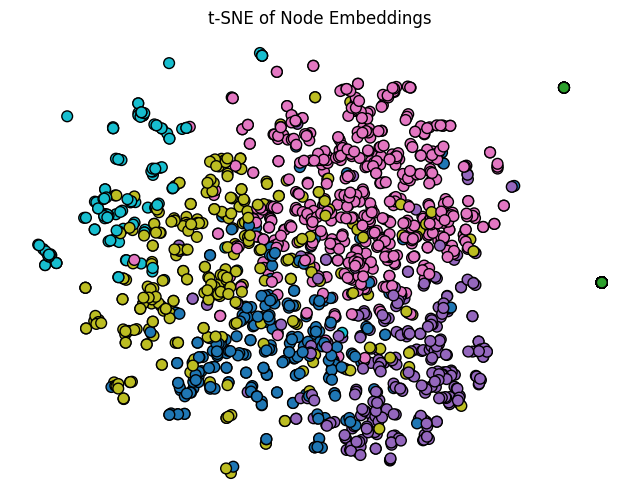

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, init="random", n_init=10, random_state=1234)

# Assign nodes to classes according to which cluster they belong
cluster_labels = kmeans.fit_predict(embeddings)
plot_scatter(embeddings, cluster_labels)

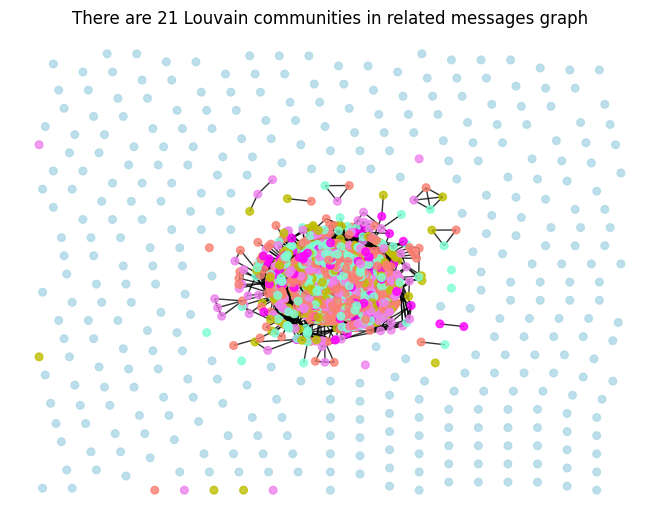

In [ ]:
node_color: list[str] = [color_list[i%len(color_list)] for i in cluster_labels]

nx.draw(G_mm,
        pos_mm,
        node_color = node_color,
        alpha = 0.8,
        node_size = 30)
_ = plt.title(f"There are {len(set(cluster_labels))} labels")

In [42]:
node_list = list(G.nodes())
for i in range(len(G_mm)):
    if cluster_labels[i] == 4:
        print(G_mm.nodes[node_list[i]]['node_value'])

**[EDIT]**: I moved this post to the project 1 tab because I felt that it was useful information. The original question was about whether the EOF token should have a newline after it or go straight to the Total Tokens line.
10
12, 7, 9, 1D right?
<@&1126568267176222800> A question for those who have taken this class already - when did you start prepping for the projects in this class? As in, today in class, prof. noted we wouldn't have all the info covered to start project 1 until the 18th. Do you think its worth it to look through it well before (say, now) or to wait until closer to that date?
<@190134597370118144> Kind of a side question, but for the union, how to you access the relations in the database?
<@190134597370118144> where did you implement the fixed point algorithm part? Did you use the return size_before - size_after in <Person>'s demo code?
<Person> gave a couple examples showing how FIRST and FOLLOW sets work in the thread above (entitled "I'm a bit confused on FIRST se